*Modelling Biological systems*

*Celia Sánchez and Lucía Chacón*

# Modelling the time evolution of COVID-19

**INDEX**

1. **Scenario 1. Interaction among people is always the same**
    * 1.1. The `S0-r`values sweep.
    * 1.2. SIR model fitting.
    * 1.3. Predicting when will be `R0`< 1 and the end of the epidemics.
    
    
2. **Scenario 2: Confinement (quarantine) starts at some time**
    * 2.1. The `q`-value sweep.
    * 2.2. SIR-SIQR model fitting.
    * 2.3. Studying the effect of different types of quarantine.
    * 2.4. Studying the effect of the date of the confinment for a level of confinment q.

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
import math as m
from scipy.optimize import curve_fit

In [2]:
'The Dataset starts at 02.01.2020 and ends at 05.07.2020. We choose to convert the .csv file to .xls format and' 
'use pandas to parse it:'

data = pd.ExcelFile("COVID19_Data_Spain_ex.xls")
sheetX = data.parse(0) 
date = sheetX['Date']

#Infected and recovered people and deaths in Spain:

infected = sheetX['Infected']
deaths = sheetX['Deaths']
recovered = sheetX['Recovered']
dt = np.linspace(1,len(infected),len(infected)) # Time-vector
a = (1/2.3) #Infectivity rate
ro = (1/5.2) #Exposal rate

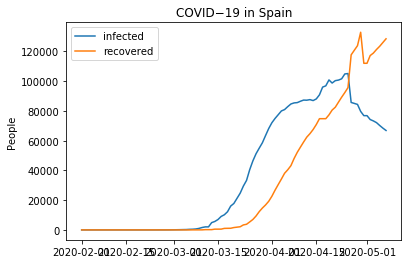

In [3]:
#Downloaded data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

## SIR epidemic model

### 1. Scenario 1: Interaction among people is always the same

In [4]:
# Defining the ODEs of the SIR system:

def SIR(I_cond,dt,r,a):
    S0,I0,R0 = I_cond #S0 = Initial susceptible people, I0 = Initial infected people, R0 = Initial removed people
    dsdt = -r*S0*I0 #r = removal rate
    didt = r*S0*I0 - a*I0
    drdt = a*I0
    return dsdt,didt,drdt

### 1.1. The `S0-r` values sweep

The SIR model is extremely sensitive to initial conditions. To fit the experimental data properly, first we need to perform an `S0` and `r` sweep to find the correct order for both variables. 

In [5]:
Ns = np.linspace(10.3**6,10.6**6,50) #Ns = Range of values for S0
Rs = np.linspace(0.545e-6,0.45e-6,50) #Rs = Range of values for r

'For each value of S0, 50 combinations of S0-r are computed. Each of these combinations has its fitting score'
'which is computed by the Square mean root. Using this score we select the best combination. '

mse = []
for n in Ns:
    mse_n = []
    for r in Rs:
        I_cond = np.array([n,infected[0],recovered[0]])
        model_SIR = odeint(SIR,I_cond,dt,args = (r,a))[:,1]        
        mse_r= np.square(np.subtract(model_SIR,infected)).mean()
        mse_n.append(mse_r)
    for m in mse_n:
        mse.append(m)

best_fit = min(mse)
index = mse.index(best_fit)
Ns_index = int(index/50)
Rs_index = int(index/50)

print('Best fit: 1.Number of population'+' '+str(Ns[Ns_index])+', '+'2. Value of r:'+' '+str(Rs[Rs_index]))

Best fit: 1.Number of population 1358966.691757, 2. Value of r: 4.7520408163265304e-07


### 1.2. SIR model fitting

Taking the values from the `S0-r` sweep, we proceed to fit the SIR model to experimental data using the `curve_fit()` function from `scipy.optimize`.

In [6]:
def SIR_fit(I_cond,dt,r):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0
    drdt = (1/2.3)*I0
    return dsdt,didt,drdt

def model_SIR(t,r,S0):
    return odeint(SIR_fit,[S0,1,0],t,args = (r,))[:,1]

In [7]:
params_SIR,params_covariance_SIR = curve_fit(model_SIR,dt,infected,[0.45e-6,1.4e6]) # S0-r sweep values
r_value_SIR = params_SIR[0]
S0_value_SIR = params_SIR[1]
print('The fitted value for r is equal to:',r_value_SIR)
print('The fitted value for the S0 population is:',S0_value_SIR)

The fitted value for r is equal to: 2.2811369474341536e-07
The fitted value for the S0 population is: 2671886.500571174


### 1.3. Predicting when will be  `R0`< 1 and the end of the epidemics.

Using the fitted SIR model, when will the reproductive number `R0` become negative and when will the epidemic end?

In [8]:
fit_SIR = list(model_SIR(dt,r_value_SIR,S0_value_SIR))
peak = max(fit_SIR)
tmax = fit_SIR.index(peak) + 1
print('R_0 will become negative after: '+str(tmax)+' days of epidemic.')

'We further extend the time vector to depict the total evolution of the epidemic:'

dt_extended = np.linspace(1,300,300)
fit_SIR_extended = model_SIR(dt_extended,r_value_SIR,S0_value_SIR)

'We assume that the epidemic will finish when the rate of infected people per day is less than 1. '

fin_SIR = 0
cont = 0
for individual in fit_SIR_extended:
    if individual < 1:
        fin_SIR = cont + 2 #0-indexing
        break 
    else: 
        cont = cont+1
        
print('No more people will get infected after '+str(fin_SIR)+' days of epidemic.')

R_0 will become negative after: 77 days of epidemic.
No more people will get infected after 172 days of epidemic.


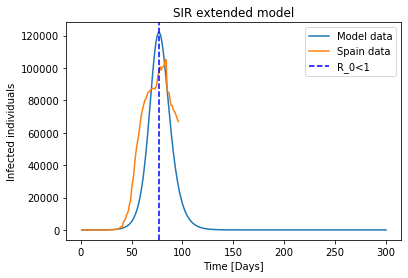

In [9]:
plt.figure(1)
plt.plot(dt_extended,fit_SIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')
plt.axvline(tmax,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()

## Scenario 2: Estimating the quarantine factor `q`

### 2.1. The `q`-value sweep

Now we consider that the interaction among people is not always the same. Once a susceptible person gets infected, there is a time delay in which the infected person can infect other people until the symptoms come up and the infected person is quarantined. To model this new situation, first we are going to consider that at day 43rd infected people will be quarantined. So we will perform a SIR model until day 43, which the SIR model will be substituted by a SIQR model.

In [10]:
#We consider the starting date of quaratine the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])

results_pre = odeint(SIR_fit,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
S, I, R = results_pre.T

#Initial conditions for the SIQR model, starting at day 43:
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]
print('The intial conditions for the confinment are S0 = ',S[-1],', I0 = ',I[-1],', R0 = ',R[-1])

The intial conditions for the confinment are S0 =  2666550.373873703 , I0 =  1526.7933921706126 , R0 =  3810.333305299144


### 2.2 SIR-SIQR model fitting

In [11]:
def SIQR(I_cond,dt,r,q):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0-q*I0 # q = quarantine factor. After the time delay infected people will be quarantined
    drdt = (1/2.3)*I0+q*I0
    return dsdt,didt,drdt

def model_SIQR(t,q):
    return np.array(odeint(SIQR,[S_new,I_new,R_new],t,args = (r_value_SIR,q))[:,1])

As we did for the scenario 1, to obtain the proper order for `q` we are going to use a sweep for different values of  `q` and compute the best fitting score. 

In [12]:
'We need to split the time-vector and infected data into two different vectors'

dt_conf = list(np.linspace(1,len(infected)-day_conf,len(infected)-day_conf))
infected_conf = infected[day_conf:] 
q_sweep = np.linspace(1e-2,1e-1,50) #Range of q-values


'The r value is obtained from the initial SIR model (the same value for scenario 1) and the initial conditions'
'were obtained modelling the first part of the system using the SIR model:'

mse_c = []
for q in q_sweep:
    function_SIQR = odeint(SIQR,[S_new,I_new,R_new],dt_conf,args = (r_value_SIR,q)) 
    S, I, R = function_SIQR.T
    mse_r= np.square(np.subtract(I,infected_conf)).mean()
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)

print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

Best fit: number of q 0.01


 Using the found q-order, we proceed to fit the SIR-SIQR model to experimental data:

In [13]:
params_SIQR, params_covariance_SIQR = curve_fit(model_SIQR,dt[day_conf:],infected_conf,1e-2) 
q_value_SIQR = params_SIQR[0]

print('The value for q is equal to:',q_value_SIQR )

The value for q is equal to: 0.002627970480552251


R_0 will become negative after: 78 days of epidemic.
No more people will get infected after 174 days of epidemic.


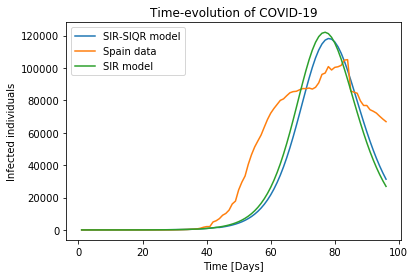

In [26]:
'Using the q-value of the fitting and the r-value of the scenario 1, we finally compute the SIR-SIQR model ' 
'The results are plotted comparing the SIR-SIQR results with experiemntal data.'

q_value=q_value_SIQR
fit_SIQR=odeint(SIQR,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q_value))
S_sweep_conf, I_sweep_conf, R_sweep_conf = fit_SIQR.T
I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

'For this case, the reproductive ratio will become negative at:'

peak_q = max(I_conf)
tmax_q = I_conf.index(peak_q) + 1
print('R_0 will become negative after: '+str(tmax_q)+' days of epidemic.')


'Moreover, the epidemic will end at:'

dt_SIQR_extend = np.linspace(1,300,300)
fit_SIQR_extend =odeint(SIQR,[S_new,I_new,R_new],dt_SIQR_extend[day_conf:],args = (r_value_SIR,q_value))[:,1]
I_conf_extend = list(fit_SIR_extended[0:day_conf])
I_conf_extend.extend(fit_SIQR_extend)

fin_SIQR = 0
cont_q = 0
for individual in I_conf_extend:
    if individual < 1:
        fin_SIQR = cont_q + 2 #0-indexing
        break 
    else: 
        cont_q = cont_q+1
        
print('No more people will get infected after '+str(fin_SIQR)+' days of epidemic.')


#plot:
plt.figure(1)
plt.plot(dt,I_conf,label='SIR-SIQR model')
plt.plot(dt,infected,label='Spain data')
plt.plot(dt,fit_SIR, label = 'SIR model')
plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('Time-evolution of COVID-19')
plt.legend(loc='best')
plt.show()

As it can be seen by the last figure, the SIR-SIQR system models better the experimental data than SIR did in scenario 1. Indeed, the SIQR reduces the spread of the disease among susceptible people.

### 2.3. Studying the effect of different types of quarantine

At this point of the study, we are going to analyze the effect of different types of quarantine (less or more restrictive) and how it does affect the total number of infected people. We will use the same SIR-SIQR model and the starting confinement date as 43.

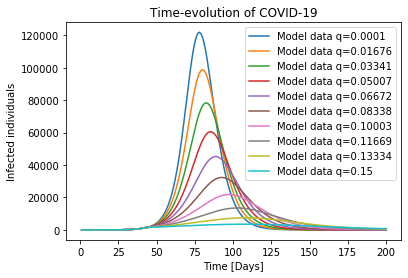

,I_max,When R0 becomes <1,q
0,121934.0,[77],0.000100
1,98819.0,[79],0.016756
2,78334.0,[81],0.033411
3,60552.0,[84],0.050067
4,45228.0,[88],0.066722
5,32343.0,[92],0.083378
6,21803.0,[96],0.100033
7,13534.0,[102],0.116689
8,7468.0,[107],0.133344
9,3542.0,[106],0.150000


In [19]:
#we set the date of confinment to 43
d=43
#we sweep the value of q
q_sweep=np.linspace(1e-4,1.5e-1,10)
#time before
dt_pre_conf=np.linspace(1,d,d)
#total time
dt_extended=np.linspace(1,200,200)


#before
results_pre = odeint(SIR_fit,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
S, I, R = results_pre.T
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]

#after
I_max=[]
day_max=[]
for q in q_sweep:
    SIR_results_conf=odeint(SIQR,[S_new,I_new,R_new],dt_extended[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data q={}'.format(round(q,5)))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('Time-evolution of COVID-19')
plt.legend(loc='best')
plt.show()
data = {'q': list(q_sweep),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

The more restrictive is a quarantine, the less people will get infected. 

### 2.4. Studying the effect of the date of the confinment for a level of confinment q.

In this exercise q-value was fixed with one of the values from the last exercise for a better resolution of the results.

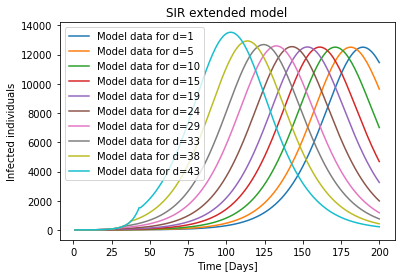

,Date,I_max,When R0 becomes <1
0,1,12511.0,[188]
1,5,12512.0,[180]
2,10,12514.0,[170]
3,15,12519.0,[160]
4,19,12526.0,[152]
5,24,12548.0,[142]
6,29,12599.0,[132]
7,33,12689.0,[123]
8,38,12938.0,[113]
9,43,13534.0,[102]


In [44]:
#we set the level of confinment to:
q=0.116689

#we sweep the value of the day
d_list=np.linspace(1,43,10)
d_list=[int(d) for d in d_list]

#total time
dt_extended=np.linspace(1,200,200)

I_max=[]
day_max=[]

for d in d_list:
    #time before
    dt_pre_conf=np.linspace(1,d,d)
    #before
    results_pre = odeint(SIR_fit,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]

    #after
    SIR_results_conf=odeint(SIQR,[S_new,I_new,R_new],dt_extended[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data for d={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Date': list(d_list),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

From the table we can conclude that as soon as an epidemic is detected, the quarantine of infected people should be established immediately.